# Estimating the Alfven Mach Number ($M_A$)
## Method 2: Tracing the band-splitting of the type-II radio bursts in I-LOFAR

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
import sunpy
sunpy.log.setLevel(logging.WARNING) # Set SunPy's logger to only show WARNING or above

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates  # Needed for the date2num conversion
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.coordinates import SphericalScreen
from sunpy.sun import constants as const
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, PercentileInterval
from scipy.interpolate import interp1d

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is stored
data_dir = '/home/mnedal/data'

### Load traced `(f,t)` data of type IIs

In [3]:
filepaths = sorted(glob.glob(f'{data_dir}/ccuddy/*.csv'))
print(len(filepaths), *filepaths, sep='\n')

14
/home/mnedal/data/ccuddy/burst1HF_stats.csv
/home/mnedal/data/ccuddy/burst1HH_stats.csv
/home/mnedal/data/ccuddy/burst1LF_stats.csv
/home/mnedal/data/ccuddy/burst1LH_stats.csv
/home/mnedal/data/ccuddy/burst2F_stats.csv
/home/mnedal/data/ccuddy/burst2H_stats.csv
/home/mnedal/data/ccuddy/burst3HF_stats.csv
/home/mnedal/data/ccuddy/burst3HH_stats.csv
/home/mnedal/data/ccuddy/burst3LF_stats.csv
/home/mnedal/data/ccuddy/burst3LH_stats.csv
/home/mnedal/data/ccuddy/burst3MF_stats.csv
/home/mnedal/data/ccuddy/burst3MH_stats.csv
/home/mnedal/data/ccuddy/burst4F_stats.csv
/home/mnedal/data/ccuddy/burst4H_stats.csv


In [28]:
dfs = {}

for path in filepaths:
    basename = os.path.basename(path).replace('_stats.csv', '')  # e.g. 'burst2H'
    # Rename the "H" bands to "U" bands (i.e., high-band to upper-band)
    if basename.split('burst')[-1][1]=='H':
        new_basename = basename.replace('H', 'U', 1)
        dfs[new_basename] = pd.read_csv(path, usecols=['t_means', 'f_means'])
    else:
        dfs[basename] = pd.read_csv(path, usecols=['t_means', 'f_means'])

print(dfs.keys())

dict_keys(['burst1UF', 'burst1UH', 'burst1LF', 'burst1LH', 'burst2F', 'burst2U', 'burst3UF', 'burst3UH', 'burst3LF', 'burst3LH', 'burst3MF', 'burst3MH', 'burst4F', 'burst4U'])


In [5]:
# BDW  = df/f                # relative instantaneous bandwidth, from the I-LOFAR dynamic spectra
# X    = (BDW + 1)**2        # compression ratio
# beta = ...                 # plasma-to-magnetic pressure ratio, from the 2D plane-of-sky map of the MAS model

# MA_method3 = np.sqrt( X*(X + 5 + 5*beta) / 2*(4 - X) ) # for a quasi-perpendicular shock, from Vršnak et al. (2002)

In [29]:
dfs['burst4F'].head(2)

,t_means,f_means
0,19857.736146,41.066186
1,19857.736225,40.442656


In [40]:
# store Alfven Mach number
Ma_dict = {}

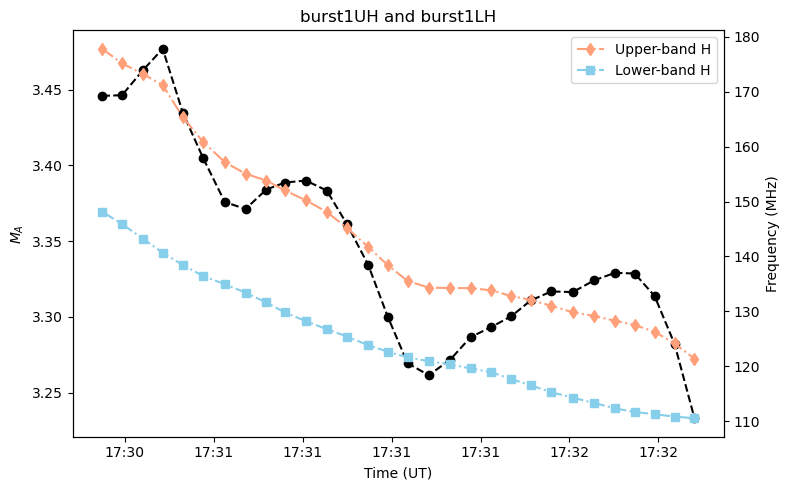

In [41]:
BDW = (dfs['burst1UH']['f_means'] - dfs['burst1LH']['f_means']) / dfs['burst1LH']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst1LH']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst1UH and burst1LH')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst1UH']['f_means'], '-.d', c='lightsalmon', label='Upper-band H')
ax2.plot(x, dfs['burst1LH']['f_means'], '-.s', c='skyblue', label='Lower-band H')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_1UH_1LH'] = MA

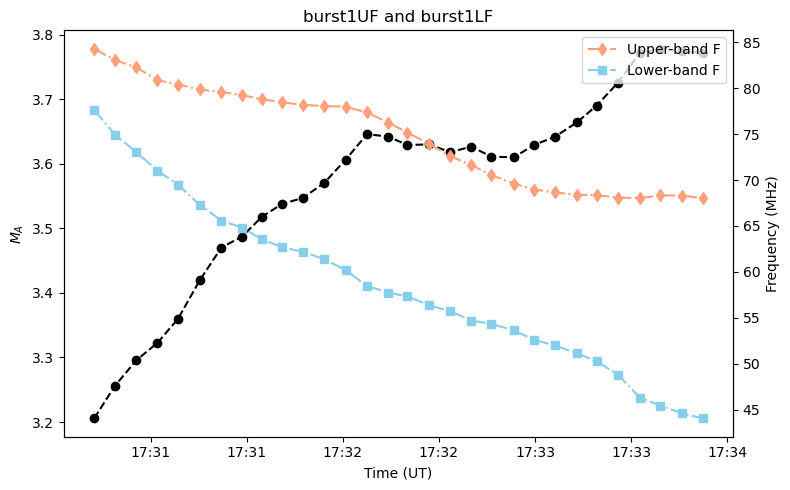

In [42]:
BDW = (dfs['burst1UF']['f_means'] - dfs['burst1LF']['f_means']) / dfs['burst1LF']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst1LF']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst1UF and burst1LF')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst1UF']['f_means'], '-.d', c='lightsalmon', label='Upper-band F')
ax2.plot(x, dfs['burst1LF']['f_means'], '-.s', c='skyblue', label='Lower-band F')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_1UF_1LF'] = MA

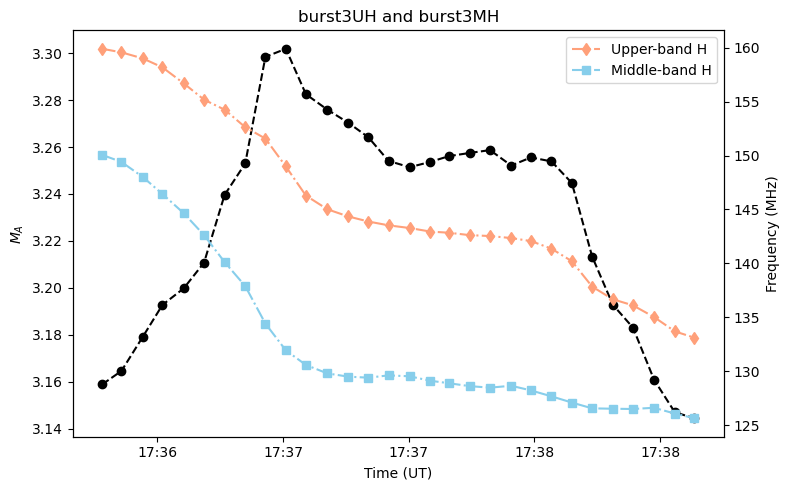

In [43]:
BDW = (dfs['burst3UH']['f_means'] - dfs['burst3MH']['f_means']) / dfs['burst3MH']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3MH']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3UH and burst3MH')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3UH']['f_means'], '-.d', c='lightsalmon', label='Upper-band H')
ax2.plot(x, dfs['burst3MH']['f_means'], '-.s', c='skyblue', label='Middle-band H')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3UH_3MH'] = MA

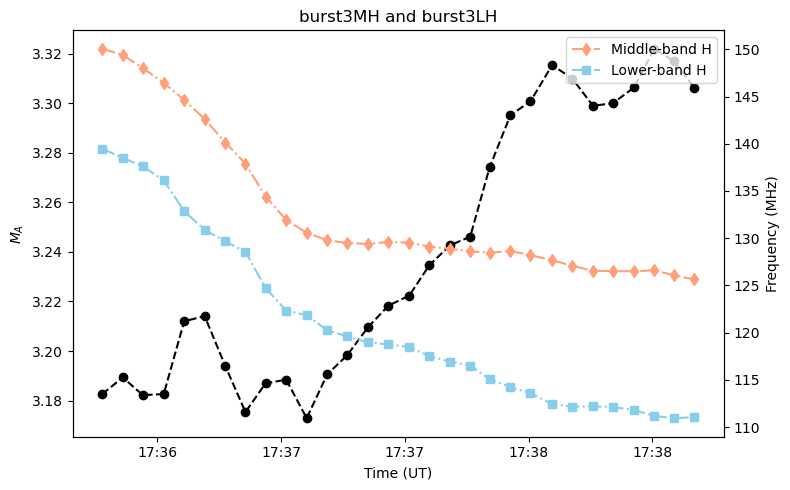

In [44]:
BDW = (dfs['burst3MH']['f_means'] - dfs['burst3LH']['f_means']) / dfs['burst3LH']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3LH']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3MH and burst3LH')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3MH']['f_means'], '-.d', c='lightsalmon', label='Middle-band H')
ax2.plot(x, dfs['burst3LH']['f_means'], '-.s', c='skyblue', label='Lower-band H')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3MH_3LH'] = MA

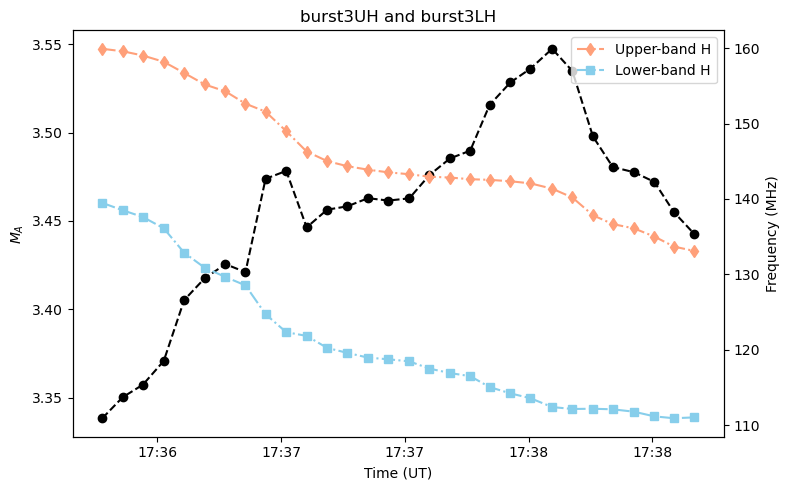

In [45]:
BDW = (dfs['burst3UH']['f_means'] - dfs['burst3LH']['f_means']) / dfs['burst3LH']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3LH']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3UH and burst3LH')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3UH']['f_means'], '-.d', c='lightsalmon', label='Upper-band H')
ax2.plot(x, dfs['burst3LH']['f_means'], '-.s', c='skyblue', label='Lower-band H')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3UH_3LH'] = MA

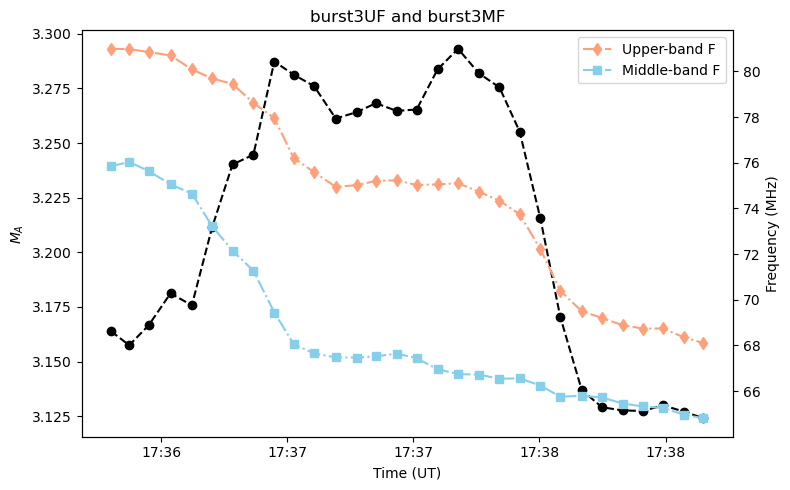

In [47]:
BDW = (dfs['burst3UF']['f_means'] - dfs['burst3MF']['f_means']) / dfs['burst3MF']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3MF']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3UF and burst3MF')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3UF']['f_means'], '-.d', c='lightsalmon', label='Upper-band F')
ax2.plot(x, dfs['burst3MF']['f_means'], '-.s', c='skyblue', label='Middle-band F')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3UF_3MF'] = MA

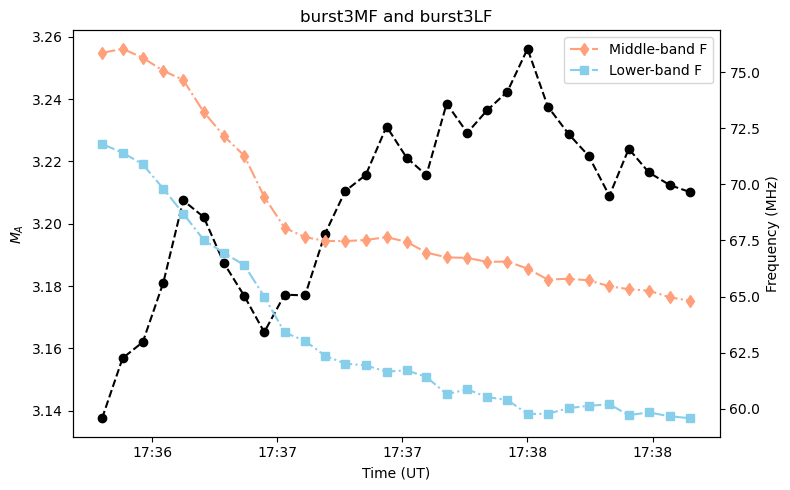

In [48]:
BDW = (dfs['burst3MF']['f_means'] - dfs['burst3LF']['f_means']) / dfs['burst3LF']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3LF']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3MF and burst3LF')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3MF']['f_means'], '-.d', c='lightsalmon', label='Middle-band F')
ax2.plot(x, dfs['burst3LF']['f_means'], '-.s', c='skyblue', label='Lower-band F')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3MF_3LF'] = MA

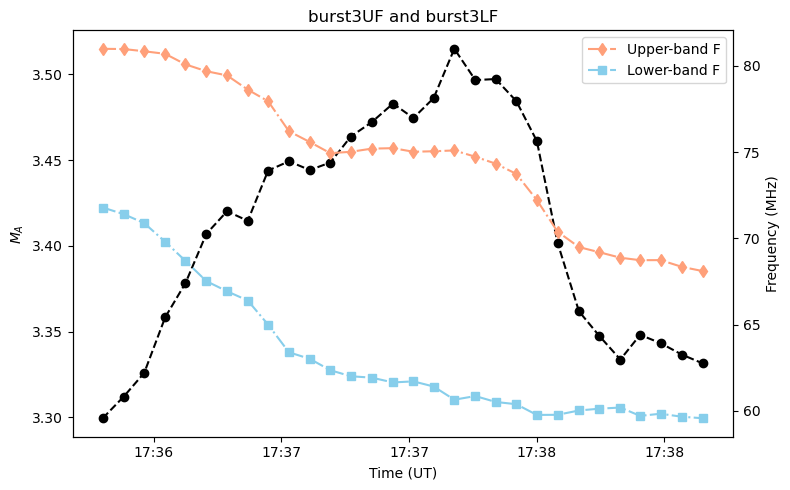

In [49]:
BDW = (dfs['burst3UF']['f_means'] - dfs['burst3LF']['f_means']) / dfs['burst3LF']['f_means']
X   = (BDW + 1)**2
MA  = np.sqrt( X*(X + 5) / 2*(4 - X) )

x = dfs['burst3LF']['t_means']

fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Left y-axis plot
ax.plot(x, MA, '--o', c='k')
ax.set_ylabel(r'$M_A$')
ax.set_xlabel('Time (UT)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('burst3UF and burst3LF')

# Right y-axis plot
ax2 = ax.twinx()
ax2.plot(x, dfs['burst3UF']['f_means'], '-.d', c='lightsalmon', label='Upper-band F')
ax2.plot(x, dfs['burst3LF']['f_means'], '-.s', c='skyblue', label='Lower-band F')
ax2.set_ylabel('Frequency (MHz)')
ax2.legend()
fig.tight_layout()
plt.show()

Ma_dict['band_3UF_3LF'] = MA

In [50]:
stats_dict = {}

for key, series in Ma_dict.items():
    values = series.values  # convert Series to ndarray
    stats_dict[key] = {
        'min': np.nanmin(values),
        'max': np.nanmax(values),
        'mean': np.nanmean(values),
        'std': np.nanstd(values)
    }

stats_MA = pd.DataFrame.from_dict(stats_dict, orient='index').round(2)

In [51]:
stats_MA

,min,max,mean,std
band_1UH_1LH,3.23,3.48,3.35,0.06
band_1UF_1LF,3.21,3.78,3.57,0.15
band_3UH_3MH,3.14,3.30,3.23,0.05
band_3MH_3LH,3.17,3.32,3.24,0.05
band_3UH_3LH,3.34,3.55,3.46,0.05
band_3UF_3MF,3.12,3.29,3.21,0.06
band_3MF_3LF,3.14,3.26,3.21,0.03
band_3UF_3LF,3.30,3.51,3.41,0.06
